# **Movie Sentiment Analysis with PyTorch and BERT Tokenizer**

**Install Required Libraries**

In [1]:
!pip install torch transformers spacy scikit-learn tqdm
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [77]:
import nbformat

# تحميل الـ notebook
with open("NLP_Final_project.ipynb", "r") as f:
    notebook = nbformat.read(f, as_version=4)

# التأكد من أن كل widget يحتوي على المفتاح 'state'
for cell in notebook.cells:
    if 'metadata' in cell and 'widgets' in cell.metadata:
        for widget in cell.metadata['widgets']:
            if 'state' not in widget:
                widget['state'] = {}  # إضافة 'state' فارغة إذا كانت مفقودة

# حفظ التغييرات
with open("fixed_notebook.ipynb", "w") as f:
    nbformat.write(notebook, f)


FileNotFoundError: [Errno 2] No such file or directory: 'NLP_Final_project.ipynb'

In [2]:
import pickle
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer
import spacy
from sklearn.model_selection import train_test_split
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np

In [3]:
import time
import warnings
from sklearn.metrics import classification_report
from tqdm import tqdm

In [4]:
!pip install fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00


In [5]:
import torch
from transformers import BertTokenizer
from fastapi import FastAPI
from pydantic import BaseModel
import spacy

**Data Loading and Preprocessing Functions:**

In [6]:
nlp = spacy.load('en_core_web_sm')

In [7]:
def load_pickle_datset(path):
    """
    Function to load a pickled data
    :param path: The path of the data
    :return: The loaded object
    """
    return pickle.load(open(path, 'rb'))

In [8]:
def clean_and_lemmatize(text):
    """
    A function that cleans the html tags and lemmatizes the text
    :param text: Text to clean
    :return: Cleaned text
    """
    if text.strip():
        text = BeautifulSoup(text, "lxml").text
        doc = nlp(text)
        lemmatized_list = [token.lemma_ for token in doc]
        return ' '.join(lemmatized_list)
    else:
        return ''

In [9]:
def save_as_pickle(data, path):
    """
    Pickling function
    :param data: data to pickle
    :param path: Path to save
    :return: None
    """
    with open(path, 'wb') as wr:
        pickle.dump(data, wr)

In [10]:
def binarize_labels(label):
    """
    A function to binarize the labels
    :param label: Label as list of text
    :return: 1/0 label
    """
    return 1 if label == 'positive' else 0

**Dataset Class**

In [11]:
class MovieDataset(Dataset):
    def __init__(self, path):
        """
        This is the heart of the Dataset class.
        1. Loading the data
        2. Tokenizing the text
        3. Padding
        4. Converting to ids
        5. Converting to tensors
        :param path: Path of the dataset
        """
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        MAX_LEN = 512
        data = load_pickle_datset(path)
        self.x = data['review'].tolist()
        self.input_lengths = []

        for i, v in enumerate(self.x):
            truncated = self.tokenizer.tokenize(v)[:MAX_LEN - 2]
            self.input_lengths.append(len(truncated) + 2)
            v = ['[CLS]'] + truncated + ['[SEP]']
            v = v + ['[PAD]'] * (MAX_LEN - len(v))
            self.x[i] = self.tokenizer.convert_tokens_to_ids(v)

        self.x = torch.tensor(self.x)
        self.y = torch.tensor(data['sentiment'].values)
        self.input_lengths = torch.tensor(self.input_lengths)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.x[idx], self.y[idx], self.input_lengths[idx]

**LSTMModel**

In [43]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_out, lstm_layers, out_dim, dropout_lstm, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.bilstm = nn.LSTM(input_size=embed_size, hidden_size=lstm_out, num_layers=lstm_layers, batch_first=True,
                              dropout=dropout_lstm, bidirectional=True)
        self.dense1 = nn.Linear(lstm_out * 2, 20)
        self.dense2 = nn.Linear(20, 10)
        self.output = nn.Linear(10, out_dim)
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, input_ids, input_lengths, targets=None):
        x = self.embedding(input_ids)
        x = self.drop1(x)
        packed_x = nn.utils.rnn.pack_padded_sequence(x, input_lengths, batch_first=True, enforce_sorted=False)
        output, (h_n, c_n) = self.bilstm(packed_x)
        output_unpacked, output_lengths = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        out = output_unpacked[:, 0, :]
        out = self.leaky_relu(out)
        out = self.leaky_relu(self.drop2(self.dense1(out)))
        out = self.leaky_relu(self.drop2(self.dense2(out)))
        out = self.output(out)
        out = self.sigmoid(out)
        out = out.view(-1)
        if targets is not None:
            criterion = nn.BCELoss()
            loss = criterion(out, targets.float())
            return out, loss
        else:
            return out,

**Training**

In [13]:
def train_step(model, batch, optimizer):
    model.train()
    optimizer.zero_grad()
    input_ids, targets, input_lengths = batch
    out, loss = model(input_ids=input_ids.to(device),
                      input_lengths=input_lengths.tolist(),
                      targets=targets.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

In [14]:
def eval_step(model, batch):
    model.eval()
    input_ids, targets, input_lengths = batch
    out, loss = model(input_ids=input_ids.to(device),
                      input_lengths=input_lengths.tolist(),
                      targets=targets.to(device))
    return loss.item()

In [15]:
def predicting(model, batch):
    model.eval()
    input_ids, _, input_lengths = batch
    out, = model(input_ids=input_ids.to(device),
                 input_lengths=input_lengths.tolist())
    return out

In [16]:
def get_class(t):
    return (t >= 0.5) * 1

In [17]:
def save_model(model, epoch, optimizer, loss, path):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss}, path)

In [18]:
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [19]:
df = pd.read_csv('IMDB Dataset.csv')

In [20]:
df_sample = df.sample(n=5000, random_state=42)

In [21]:
df_sample.head()

,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative


In [22]:
df_sample['review'] = df_sample['review'].apply(clean_and_lemmatize)

In [23]:
df_sample['sentiment'] = df_sample['sentiment'].apply(binarize_labels)
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [24]:
train_df, test_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample['sentiment'])

In [25]:
with open('train_15K.pkl', 'wb') as f:
    pickle.dump(train_df, f)

In [26]:
with open('test_15K.pkl', 'wb') as f:
    pickle.dump(test_df, f)

In [27]:
print("Train and Test files saved successfully.")

Train and Test files saved successfully.


In [28]:
df_sample

,review,sentiment
33553,I really like this Summerslam due to the look ...,1
9427,not many television show appeal to quite as ma...,1
199,the film quickly get to a major chase scene wi...,0
12447,Jane Austen would definitely approve of this o...,1
39489,expectation be somewhat high for I when I go t...,0
...,...,...
39885,one of eastwood 's good movie after he have se...,1
17566,my blurred childhood memory have keep the echo...,0
16062,I love Zombie - Movies and I love amateur - pr...,0
48445,Chan be in New York and he get involve with an...,1


**Main Script** --> Running the Model

In [29]:
import os
os.makedirs('models', exist_ok=True)

In [30]:
import os
print(os.listdir())

['.config', 'test_15K.pkl', 'train_15K.pkl', 'IMDB Dataset.csv', 'models', 'sample_data']


In [31]:
from torch.utils.data import DataLoader

In [32]:
import os

if __name__ == '__main__':
    warnings.filterwarnings("ignore")

    os.makedirs('models', exist_ok=True)

    train_dataset = MovieDataset('train_15K.pkl')
    train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=1)

    eval_dataset = MovieDataset('test_15K.pkl')
    eval_dataloader = DataLoader(eval_dataset, batch_size=512, shuffle=True, num_workers=1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = LSTMModel(vocab_size=train_dataset.tokenizer.vocab_size,
                      embed_size=50,
                      lstm_out=50,
                      lstm_layers=2,
                      out_dim=1,
                      dropout_lstm=0.6,
                      dropout=0.6)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    min_eval_loss = float('inf')

    for epoch in range(1000):
        running_train_loss = 0.0
        model.train()

        # Training loop
        for batch in tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch+1} Training"):
            running_train_loss += train_step(model, batch, optimizer)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1} || Train Loss: {running_train_loss}')

        # Validation loop
        if (epoch + 1) % 10 == 0:
            model.eval()
            running_eval_loss = 0.0
            with torch.no_grad():
                for batch in tqdm(eval_dataloader, total=len(eval_dataloader), desc=f"Epoch {epoch+1} Validation"):
                    running_eval_loss += eval_step(model, batch)

            print(f'Epoch {epoch+1} || Eval Loss: {running_eval_loss}')

            if running_eval_loss < min_eval_loss:
                min_eval_loss = running_eval_loss
                save_model(model=model, epoch=epoch + 1, optimizer=optimizer,
                           loss=min_eval_loss, path=f'models/model-{epoch + 1}.pt')

            torch.cuda.empty_cache()
        if (epoch + 1) % 50 == 0:
            torch.cuda.empty_cache()

    print("Training completed!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Epoch 5 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 5 || Train Loss: 5.548904478549957


Epoch 10 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 10 || Train Loss: 5.536851346492767


Epoch 10 Validation: 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Epoch 10 || Eval Loss: 1.3728331327438354


Epoch 15 Training: 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 15 || Train Loss: 5.392114162445068


Epoch 20 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 20 || Train Loss: 5.133905112743378


Epoch 20 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.58it/s]


Epoch 20 || Eval Loss: 1.3121673464775085


Epoch 25 Training: 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 25 || Train Loss: 4.500599265098572


Epoch 30 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 30 || Train Loss: 4.182304918766022


Epoch 30 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.79it/s]


Epoch 30 || Eval Loss: 1.1050291061401367


Epoch 35 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 35 || Train Loss: 3.2065829038619995


Epoch 40 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 40 || Train Loss: 2.936409056186676


Epoch 40 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


Epoch 40 || Eval Loss: 1.2634701132774353


Epoch 45 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 45 || Train Loss: 2.3909959197044373


Epoch 50 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 50 || Train Loss: 2.608422487974167


Epoch 50 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.39it/s]


Epoch 50 || Eval Loss: 1.6872779726982117


Epoch 55 Training: 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 55 || Train Loss: 2.057370662689209


Epoch 60 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 60 || Train Loss: 1.7442870736122131


Epoch 60 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.71it/s]


Epoch 60 || Eval Loss: 2.300892472267151


Epoch 65 Training: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 65 || Train Loss: 1.4204900115728378


Epoch 70 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 70 || Train Loss: 1.5693923234939575


Epoch 70 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.48it/s]


Epoch 70 || Eval Loss: 1.8550999760627747


Epoch 75 Training: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 75 || Train Loss: 1.3067289739847183


Epoch 80 Training: 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 80 || Train Loss: 1.346925675868988


Epoch 80 Validation: 100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


Epoch 80 || Eval Loss: 2.676393747329712


Epoch 85 Training: 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 85 || Train Loss: 1.0184059664607048


Epoch 90 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 90 || Train Loss: 1.0222508385777473


Epoch 90 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.94it/s]


Epoch 90 || Eval Loss: 4.851450204849243


Epoch 95 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 95 || Train Loss: 0.7716211602091789


Epoch 100 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 100 || Train Loss: 0.812246523797512


Epoch 100 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.52it/s]


Epoch 100 || Eval Loss: 6.56501841545105


Epoch 105 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 105 || Train Loss: 0.7020684629678726


Epoch 110 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 110 || Train Loss: 0.7586279585957527


Epoch 110 Validation: 100%|██████████| 2/2 [00:00<00:00,  7.99it/s]


Epoch 110 || Eval Loss: 7.826697587966919


Epoch 115 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 115 || Train Loss: 0.585818950086832


Epoch 120 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 120 || Train Loss: 0.6925561688840389


Epoch 120 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.40it/s]


Epoch 120 || Eval Loss: 6.261884927749634


Epoch 125 Training: 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 125 || Train Loss: 0.7180202007293701


Epoch 130 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 130 || Train Loss: 0.6291109696030617


Epoch 130 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.40it/s]


Epoch 130 || Eval Loss: 7.611412048339844


Epoch 135 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 135 || Train Loss: 0.4770292602479458


Epoch 140 Training: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 140 || Train Loss: 0.5341154113411903


Epoch 140 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.55it/s]


Epoch 140 || Eval Loss: 9.853499174118042


Epoch 145 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 145 || Train Loss: 1.1196913607418537


Epoch 150 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 150 || Train Loss: 0.5282611697912216


Epoch 150 Validation: 100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


Epoch 150 || Eval Loss: 10.954125881195068


Epoch 155 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 155 || Train Loss: 0.608846440911293


Epoch 160 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 160 || Train Loss: 0.9190842248499393


Epoch 160 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.41it/s]


Epoch 160 || Eval Loss: 13.895820617675781


Epoch 165 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 165 || Train Loss: 0.33006560429930687


Epoch 170 Training: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 170 || Train Loss: 0.6203557215631008


Epoch 170 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.14it/s]


Epoch 170 || Eval Loss: 8.590097427368164


Epoch 175 Training: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 175 || Train Loss: 0.4189990162849426


Epoch 180 Training: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 180 || Train Loss: 0.2510663513094187


Epoch 180 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.28it/s]


Epoch 180 || Eval Loss: 7.67739725112915


Epoch 185 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 185 || Train Loss: 0.273136917501688


Epoch 190 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 190 || Train Loss: 0.20831986609846354


Epoch 190 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.30it/s]


Epoch 190 || Eval Loss: 10.478512287139893


Epoch 195 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 195 || Train Loss: 0.6482370719313622


Epoch 200 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 200 || Train Loss: 0.198599049821496


Epoch 200 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.78it/s]


Epoch 200 || Eval Loss: 12.573635578155518


Epoch 205 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 205 || Train Loss: 0.17363947443664074


Epoch 210 Training: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 210 || Train Loss: 0.25690463930368423


Epoch 210 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.41it/s]


Epoch 210 || Eval Loss: 10.226100444793701


Epoch 215 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 215 || Train Loss: 0.34383806213736534


Epoch 220 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 220 || Train Loss: 0.16406374145299196


Epoch 220 Validation: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


Epoch 220 || Eval Loss: 12.814636707305908


Epoch 225 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 225 || Train Loss: 0.17644763551652431


Epoch 230 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 230 || Train Loss: 0.4969503618776798


Epoch 230 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.37it/s]


Epoch 230 || Eval Loss: 7.843387603759766


Epoch 235 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 235 || Train Loss: 0.2307568434625864


Epoch 240 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 240 || Train Loss: 0.1756706666201353


Epoch 240 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.35it/s]


Epoch 240 || Eval Loss: 10.167397499084473


Epoch 245 Training: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 245 || Train Loss: 0.2321964967995882


Epoch 250 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 250 || Train Loss: 0.17720029689371586


Epoch 250 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.36it/s]


Epoch 250 || Eval Loss: 10.14621114730835


Epoch 255 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 255 || Train Loss: 0.13779311906546354


Epoch 260 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 260 || Train Loss: 0.1400737171061337


Epoch 260 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.15it/s]


Epoch 260 || Eval Loss: 10.072927474975586


Epoch 265 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 265 || Train Loss: 0.4582559447735548


Epoch 270 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 270 || Train Loss: 0.1582070654258132


Epoch 270 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.25it/s]


Epoch 270 || Eval Loss: 11.699226379394531


Epoch 275 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 275 || Train Loss: 0.189400902017951


Epoch 280 Training: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 280 || Train Loss: 0.1269915271550417


Epoch 280 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.28it/s]


Epoch 280 || Eval Loss: 14.267915725708008


Epoch 285 Training: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 285 || Train Loss: 0.10982311051338911


Epoch 290 Training: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 290 || Train Loss: 0.08397147711366415


Epoch 290 Validation: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]


Epoch 290 || Eval Loss: 13.15878677368164


Epoch 295 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 295 || Train Loss: 0.17845157906413078


Epoch 300 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 300 || Train Loss: 0.21664307732135057


Epoch 300 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.65it/s]


Epoch 300 || Eval Loss: 12.798410415649414


Epoch 305 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 305 || Train Loss: 0.12242698483169079


Epoch 310 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 310 || Train Loss: 0.17285441793501377


Epoch 310 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.51it/s]


Epoch 310 || Eval Loss: 11.847817420959473


Epoch 315 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 315 || Train Loss: 0.08432302065193653


Epoch 320 Training: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 320 || Train Loss: 0.19702535774558783


Epoch 320 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s]


Epoch 320 || Eval Loss: 12.84272289276123


Epoch 325 Training: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Epoch 325 || Train Loss: 0.521665439940989


Epoch 330 Training: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Epoch 330 || Train Loss: 0.3374768001958728


Epoch 330 Validation: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Epoch 330 || Eval Loss: 18.204971313476562


Epoch 335 Training: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Epoch 335 || Train Loss: 0.1295125400647521


Epoch 340 Training: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Epoch 340 || Train Loss: 0.15318116126582026


Epoch 340 Validation: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Epoch 340 || Eval Loss: 10.253278732299805


Epoch 345 Training: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Epoch 345 || Train Loss: 0.21472257748246193


Epoch 350 Training: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Epoch 350 || Train Loss: 0.15383893810212612


Epoch 350 Validation: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


Epoch 350 || Eval Loss: 8.922176837921143


Epoch 355 Training: 100%|██████████| 8/8 [00:04<00:00,  1.60it/s]


Epoch 355 || Train Loss: 0.12499963399022818


Epoch 360 Training: 100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


Epoch 360 || Train Loss: 0.19168673176318407


Epoch 360 Validation: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Epoch 360 || Eval Loss: 11.64978837966919


Epoch 365 Training: 100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


Epoch 365 || Train Loss: 0.10395966563373804


Epoch 370 Training: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


Epoch 370 || Train Loss: 0.18053291365504265


Epoch 370 Validation: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


Epoch 370 || Eval Loss: 10.315355777740479


Epoch 375 Training: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Epoch 375 || Train Loss: 0.10105582023970783


Epoch 380 Training: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch 380 || Train Loss: 0.3588641230016947


Epoch 380 Validation: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Epoch 380 || Eval Loss: 15.965843677520752


Epoch 385 Training: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 385 || Train Loss: 0.1370435319840908


Epoch 390 Training: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Epoch 390 || Train Loss: 0.06671384396031499


Epoch 390 Validation: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Epoch 390 || Eval Loss: 11.877887725830078


Epoch 395 Training: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Epoch 395 || Train Loss: 0.07817935245111585


Epoch 400 Training: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch 400 || Train Loss: 0.09332582633942366


Epoch 400 Validation: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


Epoch 400 || Eval Loss: 11.638138771057129


Epoch 405 Training: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 405 || Train Loss: 0.09828204987570643


Epoch 410 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 410 || Train Loss: 0.12465587351471186


Epoch 410 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.01it/s]


Epoch 410 || Eval Loss: 11.394951343536377


Epoch 415 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 415 || Train Loss: 0.0647653026971966


Epoch 420 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 420 || Train Loss: 0.15757737681269646


Epoch 420 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.88it/s]


Epoch 420 || Eval Loss: 12.851359844207764


Epoch 425 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 425 || Train Loss: 0.6057913824915886


Epoch 430 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 430 || Train Loss: 0.1311011090874672


Epoch 430 Validation: 100%|██████████| 2/2 [00:00<00:00,  8.62it/s]


Epoch 430 || Eval Loss: 9.12513017654419


Epoch 435 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 435 || Train Loss: 0.11191210383549333


Epoch 440 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 440 || Train Loss: 0.09607407450675964


Epoch 440 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.76it/s]


Epoch 440 || Eval Loss: 16.685769081115723


Epoch 445 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 445 || Train Loss: 0.09297345601953566


Epoch 450 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 450 || Train Loss: 0.07553894515149295


Epoch 450 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.07it/s]


Epoch 450 || Eval Loss: 14.688467025756836


Epoch 455 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 455 || Train Loss: 0.08708840375766158


Epoch 460 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 460 || Train Loss: 0.125742063857615


Epoch 460 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.73it/s]


Epoch 460 || Eval Loss: 14.48451566696167


Epoch 465 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 465 || Train Loss: 0.08405272848904133


Epoch 470 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 470 || Train Loss: 0.14570905920118093


Epoch 470 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.84it/s]


Epoch 470 || Eval Loss: 10.628440856933594


Epoch 475 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 475 || Train Loss: 0.07018751185387373


Epoch 480 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 480 || Train Loss: 0.10002629179507494


Epoch 480 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.68it/s]


Epoch 480 || Eval Loss: 12.209828853607178


Epoch 485 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 485 || Train Loss: 0.08225972671061754


Epoch 490 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 490 || Train Loss: 0.12462368607521057


Epoch 490 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.20it/s]


Epoch 490 || Eval Loss: 13.996877670288086


Epoch 495 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 495 || Train Loss: 0.05168767645955086


Epoch 500 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 500 || Train Loss: 0.10426483023911715


Epoch 500 Validation: 100%|██████████| 2/2 [00:00<00:00,  8.62it/s]


Epoch 500 || Eval Loss: 14.35563325881958


Epoch 505 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 505 || Train Loss: 0.10105626727454364


Epoch 510 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 510 || Train Loss: 0.08829755149781704


Epoch 510 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.35it/s]


Epoch 510 || Eval Loss: 13.051002025604248


Epoch 515 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 515 || Train Loss: 0.06454507308080792


Epoch 520 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 520 || Train Loss: 0.28751786798238754


Epoch 520 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.68it/s]


Epoch 520 || Eval Loss: 17.324920654296875


Epoch 525 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 525 || Train Loss: 0.08278135769069195


Epoch 530 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 530 || Train Loss: 0.04720426583662629


Epoch 530 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.71it/s]


Epoch 530 || Eval Loss: 14.207935333251953


Epoch 535 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 535 || Train Loss: 0.11943683866411448


Epoch 540 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 540 || Train Loss: 0.057255905820056796


Epoch 540 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.74it/s]


Epoch 540 || Eval Loss: 13.515233993530273


Epoch 545 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 545 || Train Loss: 0.058432379039004445


Epoch 550 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 550 || Train Loss: 0.09865010622888803


Epoch 550 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.21it/s]


Epoch 550 || Eval Loss: 13.963732242584229


Epoch 555 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 555 || Train Loss: 0.08665631664916873


Epoch 560 Training: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 560 || Train Loss: 0.07557206740602851


Epoch 560 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.04it/s]


Epoch 560 || Eval Loss: 15.447678089141846


Epoch 565 Training: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 565 || Train Loss: 0.10282921232283115


Epoch 570 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 570 || Train Loss: 0.052887768018990755


Epoch 570 Validation: 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Epoch 570 || Eval Loss: 17.779417037963867


Epoch 575 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 575 || Train Loss: 0.0856101387180388


Epoch 580 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 580 || Train Loss: 0.09857098525390029


Epoch 580 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.56it/s]


Epoch 580 || Eval Loss: 15.956738471984863


Epoch 585 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 585 || Train Loss: 0.15684940107166767


Epoch 590 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 590 || Train Loss: 0.10014076111838222


Epoch 590 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.34it/s]


Epoch 590 || Eval Loss: 13.315267562866211


Epoch 595 Training: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 595 || Train Loss: 0.07515428611077368


Epoch 600 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 600 || Train Loss: 0.07864286191761494


Epoch 600 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


Epoch 600 || Eval Loss: 15.956756114959717


Epoch 605 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 605 || Train Loss: 0.09613936115056276


Epoch 610 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 610 || Train Loss: 0.07888571079820395


Epoch 610 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.21it/s]


Epoch 610 || Eval Loss: 15.33226490020752


Epoch 615 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 615 || Train Loss: 0.09023494506254792


Epoch 620 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 620 || Train Loss: 0.05997063498944044


Epoch 620 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.76it/s]


Epoch 620 || Eval Loss: 15.859984874725342


Epoch 625 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 625 || Train Loss: 0.0645911623723805


Epoch 630 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 630 || Train Loss: 0.07710844743996859


Epoch 630 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.68it/s]


Epoch 630 || Eval Loss: 17.596235275268555


Epoch 635 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 635 || Train Loss: 0.04755634313914925


Epoch 640 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 640 || Train Loss: 0.08032884844578803


Epoch 640 Validation: 100%|██████████| 2/2 [00:00<00:00,  8.54it/s]


Epoch 640 || Eval Loss: 17.206554889678955


Epoch 645 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 645 || Train Loss: 0.0433614767389372


Epoch 650 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 650 || Train Loss: 0.05920576141215861


Epoch 650 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.78it/s]


Epoch 650 || Eval Loss: 19.832804679870605


Epoch 655 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 655 || Train Loss: 0.0631626236718148


Epoch 660 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 660 || Train Loss: 0.0848138676956296


Epoch 660 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.04it/s]


Epoch 660 || Eval Loss: 18.221224784851074


Epoch 665 Training: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 665 || Train Loss: 0.05733520467765629


Epoch 670 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 670 || Train Loss: 0.04388612590264529


Epoch 670 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.90it/s]


Epoch 670 || Eval Loss: 19.5179443359375


Epoch 675 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 675 || Train Loss: 0.056142379296943545


Epoch 680 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 680 || Train Loss: 0.0966455452144146


Epoch 680 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.74it/s]


Epoch 680 || Eval Loss: 16.313233375549316


Epoch 685 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 685 || Train Loss: 0.06175915733911097


Epoch 690 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 690 || Train Loss: 0.11363473115488887


Epoch 690 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


Epoch 690 || Eval Loss: 17.107266426086426


Epoch 695 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 695 || Train Loss: 0.059222700307145715


Epoch 700 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 700 || Train Loss: 0.07498976495116949


Epoch 700 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.79it/s]


Epoch 700 || Eval Loss: 19.602153778076172


Epoch 705 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 705 || Train Loss: 0.09998641209676862


Epoch 710 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 710 || Train Loss: 0.06122868647798896


Epoch 710 Validation: 100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


Epoch 710 || Eval Loss: 19.066887855529785


Epoch 715 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 715 || Train Loss: 0.06920604803599417


Epoch 720 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 720 || Train Loss: 0.06725678429938853


Epoch 720 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.60it/s]


Epoch 720 || Eval Loss: 19.65591812133789


Epoch 725 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 725 || Train Loss: 0.06258076196536422


Epoch 730 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 730 || Train Loss: 0.06870318576693535


Epoch 730 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.63it/s]


Epoch 730 || Eval Loss: 17.985465049743652


Epoch 735 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 735 || Train Loss: 0.06445389369037002


Epoch 740 Training: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 740 || Train Loss: 0.06222161208279431


Epoch 740 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.77it/s]


Epoch 740 || Eval Loss: 16.714083671569824


Epoch 745 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 745 || Train Loss: 0.04910744819790125


Epoch 750 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 750 || Train Loss: 0.07321315817534924


Epoch 750 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


Epoch 750 || Eval Loss: 19.080890655517578


Epoch 755 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 755 || Train Loss: 0.08243762562051415


Epoch 760 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 760 || Train Loss: 0.26819514064118266


Epoch 760 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.59it/s]


Epoch 760 || Eval Loss: 17.990833282470703


Epoch 765 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 765 || Train Loss: 0.12199558224529028


Epoch 770 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 770 || Train Loss: 0.05007079290226102


Epoch 770 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.56it/s]


Epoch 770 || Eval Loss: 17.23818016052246


Epoch 775 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 775 || Train Loss: 0.08215628238394856


Epoch 780 Training: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 780 || Train Loss: 0.08576720021665096


Epoch 780 Validation: 100%|██████████| 2/2 [00:00<00:00,  7.67it/s]


Epoch 780 || Eval Loss: 20.187914848327637


Epoch 785 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 785 || Train Loss: 0.07149404752999544


Epoch 790 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 790 || Train Loss: 0.04985702014528215


Epoch 790 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.90it/s]


Epoch 790 || Eval Loss: 17.151765823364258


Epoch 795 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 795 || Train Loss: 0.06497654179111123


Epoch 800 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 800 || Train Loss: 0.0819175518117845


Epoch 800 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.73it/s]


Epoch 800 || Eval Loss: 19.424097061157227


Epoch 805 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 805 || Train Loss: 0.05480506154708564


Epoch 810 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 810 || Train Loss: 0.06081848475150764


Epoch 810 Validation: 100%|██████████| 2/2 [00:00<00:00, 10.92it/s]


Epoch 810 || Eval Loss: 19.24421787261963


Epoch 815 Training: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 815 || Train Loss: 0.05183848808519542


Epoch 820 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 820 || Train Loss: 0.06262377346865833


Epoch 820 Validation: 100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


Epoch 820 || Eval Loss: 22.077512741088867


Epoch 825 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 825 || Train Loss: 0.07048971392214298


Epoch 830 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 830 || Train Loss: 0.0985165536403656


Epoch 830 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]


Epoch 830 || Eval Loss: 22.049952507019043


Epoch 835 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 835 || Train Loss: 0.3868751674890518


Epoch 840 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 840 || Train Loss: 0.13792101945728064


Epoch 840 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.05it/s]


Epoch 840 || Eval Loss: 9.710071802139282


Epoch 845 Training: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 845 || Train Loss: 0.08897800790145993


Epoch 850 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 850 || Train Loss: 0.09433382633142173


Epoch 850 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.34it/s]


Epoch 850 || Eval Loss: 14.132503986358643


Epoch 855 Training: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 855 || Train Loss: 0.07985961809754372


Epoch 860 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 860 || Train Loss: 0.05594844277948141


Epoch 860 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.65it/s]


Epoch 860 || Eval Loss: 16.74825954437256


Epoch 865 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 865 || Train Loss: 0.06544516189023852


Epoch 870 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 870 || Train Loss: 0.049249639036133885


Epoch 870 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.44it/s]


Epoch 870 || Eval Loss: 17.73379135131836


Epoch 875 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 875 || Train Loss: 0.09142475668340921


Epoch 880 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 880 || Train Loss: 0.06626957468688488


Epoch 880 Validation: 100%|██████████| 2/2 [00:00<00:00, 10.97it/s]


Epoch 880 || Eval Loss: 19.456336975097656


Epoch 885 Training: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 885 || Train Loss: 0.041463442612439394


Epoch 890 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 890 || Train Loss: 0.04839947749860585


Epoch 890 Validation: 100%|██████████| 2/2 [00:00<00:00,  7.95it/s]


Epoch 890 || Eval Loss: 18.511603355407715


Epoch 895 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 895 || Train Loss: 0.09747096244245768


Epoch 900 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 900 || Train Loss: 0.47788111539557576


Epoch 900 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


Epoch 900 || Eval Loss: 24.475536346435547


Epoch 905 Training: 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 905 || Train Loss: 0.043856129981577396


Epoch 910 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 910 || Train Loss: 0.085254798643291


Epoch 910 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.54it/s]


Epoch 910 || Eval Loss: 14.539534091949463


Epoch 915 Training: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 915 || Train Loss: 0.05624816659837961


Epoch 920 Training: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 920 || Train Loss: 0.06515825749374926


Epoch 920 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.08it/s]


Epoch 920 || Eval Loss: 18.346433639526367


Epoch 925 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 925 || Train Loss: 0.051032529678195715


Epoch 930 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 930 || Train Loss: 0.06883972324430943


Epoch 930 Validation: 100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


Epoch 930 || Eval Loss: 20.362832069396973


Epoch 935 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 935 || Train Loss: 0.05680625629611313


Epoch 940 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 940 || Train Loss: 0.10207966202870011


Epoch 940 Validation: 100%|██████████| 2/2 [00:00<00:00, 10.84it/s]


Epoch 940 || Eval Loss: 19.270833015441895


Epoch 945 Training: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 945 || Train Loss: 0.056203515036031604


Epoch 950 Training: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 950 || Train Loss: 0.04976249532774091


Epoch 950 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.71it/s]


Epoch 950 || Eval Loss: 18.40868377685547


Epoch 955 Training: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 955 || Train Loss: 0.06326993252150714


Epoch 960 Training: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 960 || Train Loss: 0.05158892755571287


Epoch 960 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.30it/s]


Epoch 960 || Eval Loss: 18.05691146850586


Epoch 965 Training: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 965 || Train Loss: 0.057323254412040114


Epoch 970 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 970 || Train Loss: 0.05273708514869213


Epoch 970 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.31it/s]


Epoch 970 || Eval Loss: 21.820589065551758


Epoch 975 Training: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 975 || Train Loss: 0.05307776271365583


Epoch 980 Training: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 980 || Train Loss: 0.05151832988485694


Epoch 980 Validation: 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]


Epoch 980 || Eval Loss: 20.482816696166992


Epoch 985 Training: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 985 || Train Loss: 0.056168704526498914


Epoch 990 Training: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 990 || Train Loss: 0.051259195897728205


Epoch 990 Validation: 100%|██████████| 2/2 [00:00<00:00,  9.54it/s]


Epoch 990 || Eval Loss: 20.53022289276123


Epoch 995 Training: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 995 || Train Loss: 0.0507659325376153


Epoch 1000 Training: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 1000 || Train Loss: 0.051481283036991954


Epoch 1000 Validation: 100%|██████████| 2/2 [00:00<00:00,  7.79it/s]

Epoch 1000 || Eval Loss: 22.61278533935547
Training completed!


In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [34]:
lstm_model = LSTMModel(vocab_size=tokenizer.vocab_size,
                       embed_size=50,
                       lstm_out=50,
                       lstm_layers=2,
                       out_dim=1,
                       dropout_lstm=0.6,
                       dropout=0.6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model.to(device)

# Load the model's checkpoint
model_path = '/content/models/model-30.pt'  # Ensure the path is correct
try:
    loaded_chekpoints = torch.load(model_path, map_location=device)
    lstm_model.load_state_dict(loaded_chekpoints['model_state_dict'])
    lstm_model.eval()
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

# Load spaCy for text processing
nlp = spacy.load('en_core_web_sm')

# Initialize FastAPI
app = FastAPI()

# Define the input model for receiving text
class Review(BaseModel):
    text: str

# Prediction route
@app.post('/predict')
def predict_sentiment(payload: Review):
    try:
        # Clean and lemmatize the input text
        print(f"Received review: {payload.text}")
        cleaned_text = clean_and_lemmatize(payload.text)
        print(f"Cleaned text: {cleaned_text}")

        # Tokenize the cleaned text using BERT tokenizer
        tokens = tokenizer.tokenize(cleaned_text)
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        length = len(tokens)

        # Convert tokens to input IDs
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_ids = torch.tensor(input_ids).view(1, -1).to(device)

        # Run the input through the model
        out, = lstm_model(input_ids=input_ids, input_lengths=[length])
        score = out.item()

        # Determine the sentiment based on the score
        print(f"Prediction score: {score}")
        if score <= 0.25:
            tag = 'Worst'
        elif score <= 0.50:
            tag = 'Bad'
        elif score <= 0.75:
            tag = 'Good'
        else:
            tag = 'Great'

        # Return the result
        return dict(review=payload.text, score=score, tag=tag)

    except Exception as e:
        print(f"Error during prediction: {e}")
        return {"error": str(e)}

Model loaded successfully!


In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [63]:
def plot_classification_report(report):
    metrics = ['precision', 'recall', 'f1-score']
    labels = report.keys()
    data = {metric: [] for metric in metrics}

    for label in labels:
        if isinstance(report[label], dict):
            for metric in metrics:
                data[metric].append(report[label][metric])
        else:
            for metric in metrics:
                data[metric].append(report[label])

    for metric in metrics:
        data[metric] = np.array(data[metric])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, metric in enumerate(metrics):
        axes[i].bar(labels, data[metric], color='skyblue')
        axes[i].set_title(f'{metric.capitalize()}')
        axes[i].set_xlabel('Class')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

In [64]:
def evaluate_model(model, test_dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, total=len(test_dataloader), desc="Evaluating"):
            input_ids, targets, input_lengths = batch
            preds, _ = model(input_ids=input_ids.to(device),
                             input_lengths=input_lengths.tolist(),
                             targets=targets.to(device))
            preds = get_class(preds)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'], output_dict=True)

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

    plot_classification_report(report)

Evaluating: 100%|██████████| 2/2 [00:00<00:00,  9.00it/s]


Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.83      0.74       496
    Positive       0.78      0.61      0.69       504

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.72      1000
weighted avg       0.73      0.72      0.72      1000



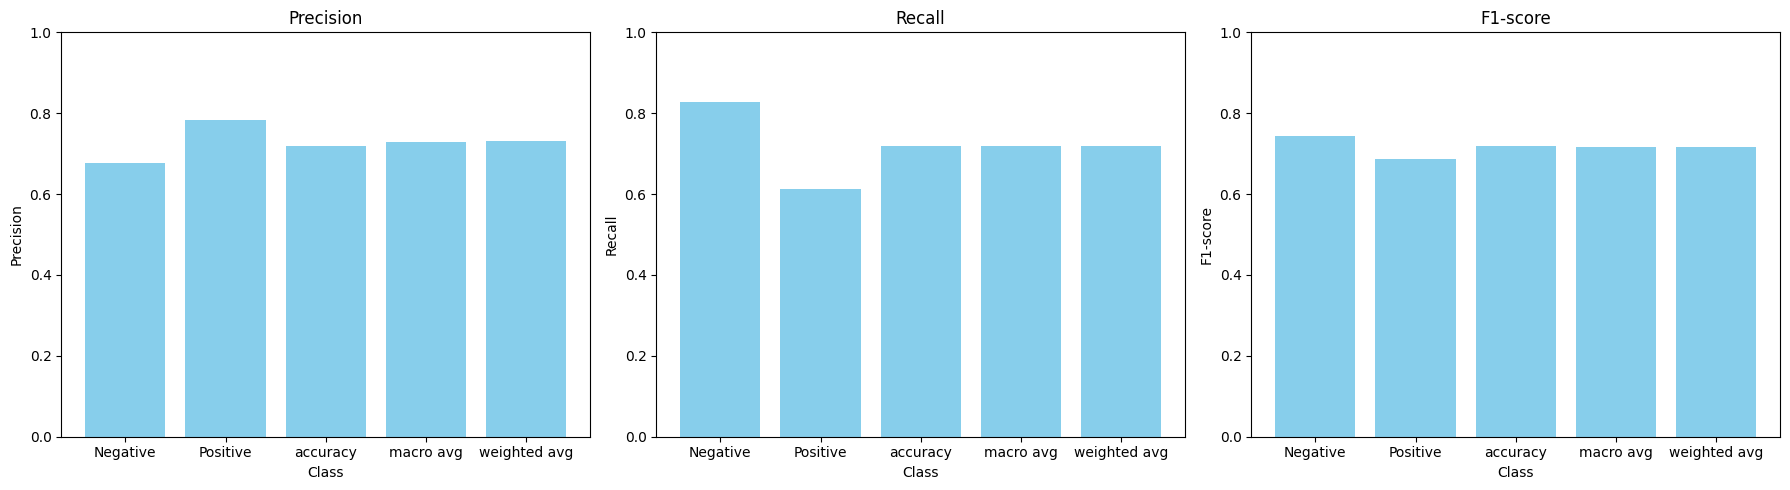

In [65]:
if __name__ == '__main__':
    warnings.filterwarnings("ignore")

    eval_dataset = MovieDataset('test_15K.pkl')
    eval_dataloader = DataLoader(eval_dataset, batch_size=512, shuffle=False, num_workers=1)

    evaluate_model(lstm_model, eval_dataloader)
